# Summary Notebook

This research aims to find an answer to three objectives:
1. What are the most important internal and external features in predicting rental prices?
2. What are the top 10 suburbs with the highest predicted growth rate?
3. What are the most liveable and affordable suburbs according to your chosen metrics?


In [1]:
from IPython import display

# Data Downloading

## Methodology

We extracted data from Domain.com using web scraping techniques. To circumvent pagination issues, we integrated postcodes directly into the URL. This approach ensured we achieved comprehensive coverage of properties throughout Victoria. In total, we scraped data for 12,014 properties.

We also sourced external datasets that include census data, population projections, offence counts, and historical rent reports. These were obtained from the Australian Bureau of Statistics (ABS), the Australian Institute of Health and Welfare, the Crime Statistics Agency, and Homes Victoria, respectively.

Additionally, datasets related to proximities were procured from ORS.

# Data Preprocessing & Aggregation

## Properties data
We verified the consistency of the 'rent' column within the properties dataset. Properties with zero values in either 'beds' or 'baths' columns were subsequently removed. Outliers within the dataset were manually inspected. After preprocessing, the properties data was aggregated to the Local Government Area (LGA) level by calculating the median. After the preprocessing, we preserved 11541 properties.

## Census data
From the Census dataset, we extracted weekly income figures based on the LGA.

## Offence Count
The Offence Count data was grouped by both year and LGA regions.

## Population data
While the initial population data was based on the SA2 level, we first mapped it to the LGA level. Subsequently, this adjusted population data was merged with the properties dataset.

## Finding Proximities
To prevent the API use restrictions, we set up ORS on docker to find out the proximities to various facilities.

## Missing Values
We found that the population data for Queenscliffe is missing, the Queenscliffe is excluded in our further analysis.

# Blockers and Assumptions
During our examination of the 'rent' column's consistency, we discovered that some rent values were recorded either on a yearly or monthly basis. However, since the column was formatted as a string, we utilized Regex for identification. This method, while effective, couldn't address all scenarios. Any remaining unidentified entries were manually inspected.

In the process of mapping between SA2 and LGA regions, if a Statistical Area Level 2 (SA2) district encompasses more than two Local Government Areas (LGAs), we selected the largest LGA for our analysis.

Since we lacked predictions for future offence counts, we employed a Random Forest algorithm to forecast the offence count for the upcoming three years.

# Choice of Granularity

- Historical rent data is accessible at the LGA level, but not for SA2. Opting for LGA not only facilitates the use of this historical data but also enhances the accuracy of our predictions.

- Additionally, the general public and potential renters are likely more acquainted with LGA names and boundaries compared to SA2 divisions. As a result, predictions grounded in LGAs might resonate better and be more intuitive for them.

# Feature Selection
We inspect the feature importance of features that make a property more expensive, the result is below. It turns out that the distrance to CBD and number of beds or baths make a property more expensive.

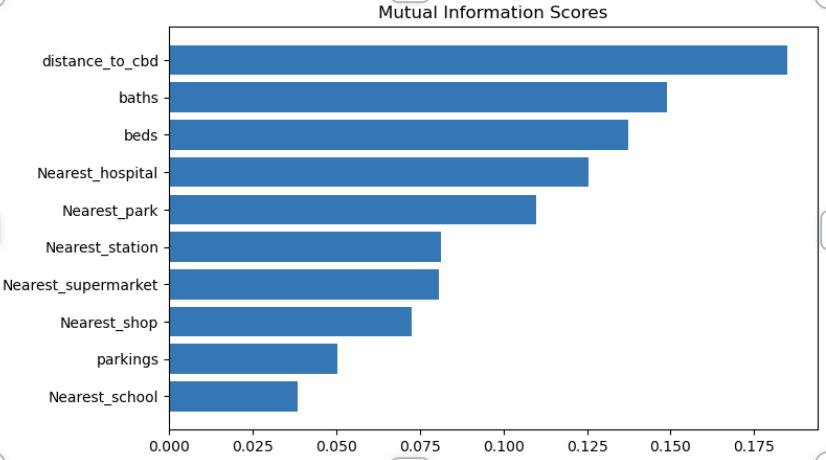

In [3]:
display.Image("../plots/feature_selection.png")

# Modelling

## Preprocessing
The dataset we utilized for prediction contains the following columns:
LGA_NAME, cost, beds, baths, parkings, Nearest_station, Nearest_park, Nearest_shop, Nearest_hospital, Nearest_school, Nearest_supermarket, distance_to_cbd, year, Offence Count, population, and weekly_income.

We applied one-hot encoding to the LGA_NAME column.
Log-transformation was performed on the numerical columns, except for beds, baths, parkings, and year, which were retained in their original form.

## Modelling
We first performed forward selection to fit a linear regression model based on AIC. The report is as below:

The model's R-squared value is 0.871, indicating that approximately 87.1% of the variance in the dependent variable, cost, can be explained by the independent variables in the model. This is a relatively high R-squared value, suggesting that the model fits the data well.

The adjusted R-squared is slightly lower at 0.860, but it's still quite high. The adjusted R-squared takes into account the number of predictors in the model, so this slight decrease is expected when adding more predictors.

The F-statistic is 82.89 with a very low associated probability (p-value of 1.83e-196). This indicates that the model is statistically significant, and the predictors in the model collectively have a significant effect on the dependent variable, cost.

We then split the training dataset into training set (2017-2022) and validation set (2023). We fit a linear regression model using the selected features from forward selection and all features for Random Forests. The linear regression gave a RMSE of 83.4 while the Random Forests gave a RMSE of 97.3.

## Comparison & Analysis:
The linear regression model outperformed the Random Forests model on the validation set, as evidenced by its lower RMSE. This suggests that, for this particular dataset and problem, a linear approach might be more suitable than the ensemble-based Random Forests. It's also worth noting that the feature selection process for the linear regression might have contributed to its superior performance by focusing on the most relevant predictors.

## Predictions
We then fit the linear regression model to the whole training set and calculate the LGAs with highest growth rates.

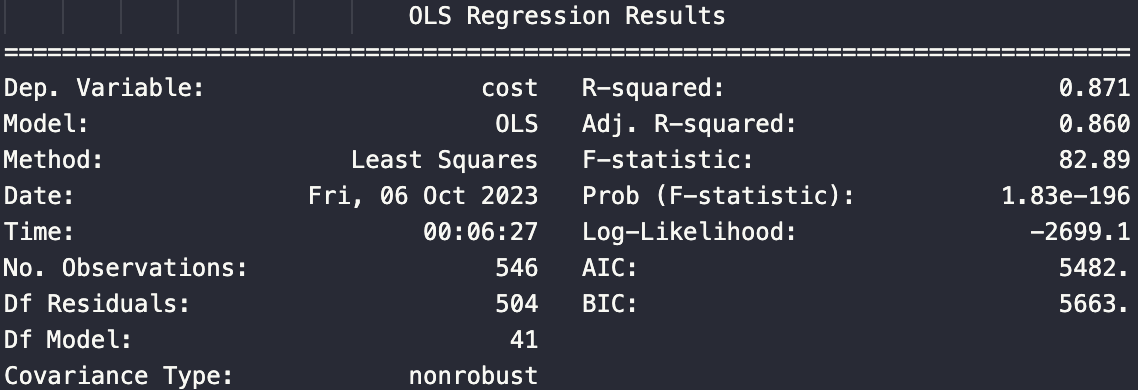

In [2]:
display.Image("../plots/LR report.png")

# Scoring

We engineered a new feature called cirminal rate derived by Offence Count/Population. We then assigned a coefficient to every column to represent